<a href="https://colab.research.google.com/github/chad-fisher/CRWA-Regional-Tree-Planting-and-Protection-Plan/blob/main/CodeNotebookInvasivesOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [6]:
#Need this because on a different computer :(
!pip install matplotlib_scalebar
!pip install contextily
!pip install wget
!pip install pyinaturalist

<IPython.core.display.HTML object>

In [99]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import ee
import geemap
import geemap.foliumap as geemapf
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import wget
import zipfile
from datetime import datetime
import pyinaturalist
from scipy import ndimage
import urllib
import altair as alt

<IPython.core.display.HTML object>

In [8]:
#Authenticate to Earth Engine
ee.Authenticate()

<IPython.core.display.HTML object>

True

In [9]:
#Initialize earth engine project
ee.Initialize(project='ee-cefisher20')

<IPython.core.display.HTML object>

# Extracting watershed boundaries

In [10]:
#HUC codes from https://apps.nationalmap.gov/viewer/
Charles=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107' or huc10 == '0109000106'")
Charles_lower=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107'")
Charles_upper=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000106'")
Charles.first().geometry().projection()

<IPython.core.display.HTML object>

<ee.projection.Projection object at 0x7b58c4bcfac0>

In [11]:
#Convert earth engine feature collections to geopandas data frames
Charles_gdf = ee.data.computeFeatures({
    'expression': Charles,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_gdf.crs = 'EPSG:4326'

Charles_lower_gdf = ee.data.computeFeatures({
    'expression': Charles_lower,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_lower_gdf.crs = 'EPSG:4326'

Charles_upper_gdf = ee.data.computeFeatures({
    'expression': Charles_upper,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_upper_gdf.crs = 'EPSG:4326'

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

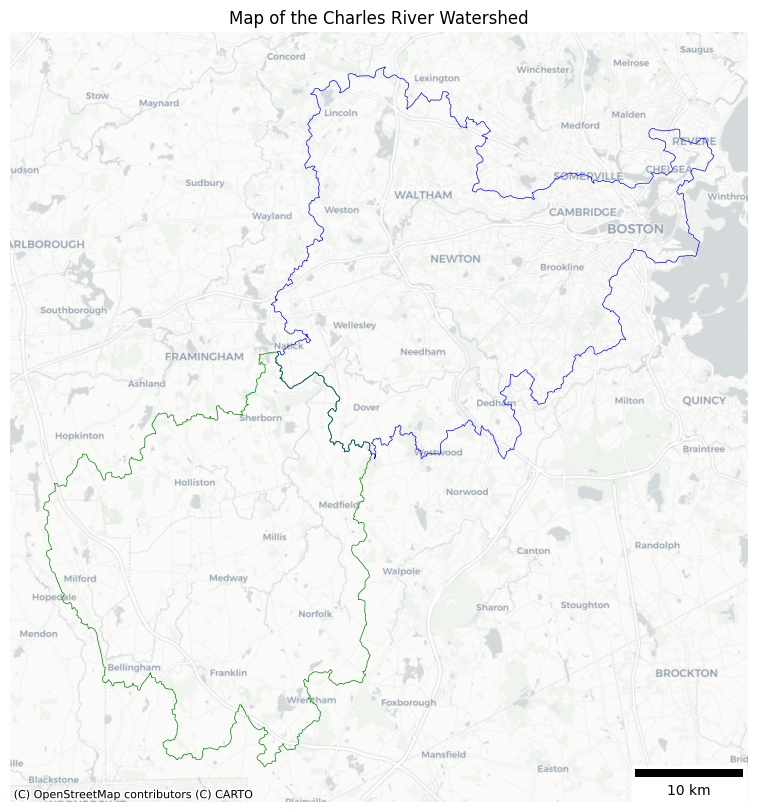

In [12]:
ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
plt.title("Map of the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Charles Watershed Maps.png")

In [13]:
#Create function to clip image to be used for clipping image collections
def Charclip(image):
    return image.clip(Charles)

<IPython.core.display.HTML object>

# Land Cover Maps

In [14]:
#Forest Areas
NLCD2019lc=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('landcover')
map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(41)),name='Deciduous Forest',color='light green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(42)),name='Evergreen Forest',color='dark green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(43)),name='Mixed Forest',color='green')
map_1

#NLCD change maps for forest types, check out different times
#Add boundary to map

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7b58c49366e0>

In [15]:
#Impervious Cover
NLCD2019=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('impervious')
map_2 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
image_viz_params = {
    'bands': ['impervious'],
    'min': 0,
    'max': 100,
    'palette': 'plasma'
}
map_2.add_layer(NLCD2019, image_viz_params)
map_2

#NLCD data from previous years to see changes

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7b58c4935e40>

# Invasive Species Data Collection

In [16]:
#Extract Sentinel 2 bands and indices of interest
def extractBandsIndices(image):
    return image.select(['B2','B3','B4','B5_10m','B6_10m','B7_10m','B8','B8A_10m','B11_10m','B12_10m',
                         'NDVI','NBR','SAVI','RENDVI','EVI'])

<IPython.core.display.HTML object>

In [17]:
#Resample Sentinel 2 bands to 10 m
def resample10m(image):
    proj_10m=image.select('B4').projection()
    B5_res=image.select('B5').resample('bicubic').reproject(proj_10m).rename('B5_10m')
    B6_res=image.select('B6').resample('bicubic').reproject(proj_10m).rename('B6_10m')
    B7_res=image.select('B7').resample('bicubic').reproject(proj_10m).rename('B7_10m')
    B8A_res=image.select('B8A').resample('bicubic').reproject(proj_10m).rename('B8A_10m')
    B11_res=image.select('B11').resample('bicubic').reproject(proj_10m).rename('B11_10m')
    B12_res=image.select('B12').resample('bicubic').reproject(proj_10m).rename('B12_10m')
    return image.addBands([B5_res,B6_res,B7_res,B8A_res,B11_res,B12_res])

<IPython.core.display.HTML object>

In [18]:
#Add 5 vegetation indices of interest
def addIndices(image):
    NDVI = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    NBR = image.normalizedDifference(['B12_10m','B8']).rename('NBR')
    SAVI = image.expression(
        '1.5 * ((NIR - RED)) / (NIR + RED + 0.5)', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
        }).rename('SAVI')
    RENDVI = image.normalizedDifference(['B6_10m','B5_10m']).rename('RENDVI')
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
            'BLUE': image.select('B2')}).rename('EVI')
    return image.addBands([NDVI,NBR,SAVI,RENDVI,EVI])

<IPython.core.display.HTML object>

In [19]:
#Cloud mask function
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    return image.updateMask(mask).divide(10000)

<IPython.core.display.HTML object>

In [20]:
#Land cover mask function
def mask_forests(image):
    mask=(NLCD2019lc.eq(41).Or(NLCD2019lc.eq(42).Or(NLCD2019lc.eq(43))))
    return image.updateMask(mask)

<IPython.core.display.HTML object>

In [103]:
#Pre-processing sentinel-2 data
S2_All=ee.ImageCollection(("COPERNICUS/S2_SR_HARMONIZED")).filterDate('2019-01-01','2023-01-01').filterBounds(Charles.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)).map(mask_s2_clouds).map(Charclip).map(resample10m).map(addIndices).map(extractBandsIndices)

<IPython.core.display.HTML object>

In [46]:
S2_All.first().geometry()

<IPython.core.display.HTML object>

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Image.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.map",
                "arguments": {
                  "baseAlgorithm": {
                    "functionDefinitionValue": {
                      "argumentNames": [
                        "_MAPPING_VAR_0_0"
                      ],
                      "body": {
                        "functionInvocationValue": {
                          "functionName": "Image.select",
                          "arguments": {
                            "bandSelectors": {
                              "constantValue": [
                                "B2",
                                "B3",
                                "B4",
                                "B5_10m",
                                "B6_10m",
                                "B7_10m",
                                "B8",
                                "B8A_10m",
                                "B11_10m",
                                "B12_10m",
                                "NDVI",
                                "NBR",
                                "SAVI",
                                "RENDVI",
                                "EVI"
                              ]
                            },
                            "input": {
                              "argumentReference": "_MAPPING_VAR_0_0"
                            }
                          }
                        }
                      }
                    }
                  },
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.map",
                      "arguments": {
                        "baseAlgorithm": {
                          "functionDefinitionValue": {
                            "argumentNames": [
                              "_MAPPING_VAR_0_0"
                            ],
                            "body": {
                              "functionInvocationValue": {
                                "functionName": "Image.addBands",
                                "arguments": {
                                  "dstImg": {
                                    "argumentReference": "_MAPPING_VAR_0_0"
                                  },
                                  "srcImg": {
                                    "functionInvocationValue": {
                                      "functionName": "Image.addBands",
                                      "arguments": {
                                        "dstImg": {
                                          "functionInvocationValue": {
                                            "functionName": "Image.addBands",
                                            "arguments": {
                                              "dstImg": {
                                                "functionInvocationValue": {
                                                  "functionName": "Image.addBands",
                                                  "arguments": {
                                                    "dstImg": {
                                                      "functionInvocationValue": {
                                                        "functionName": "Image.addBands",
                                                        "arguments": {
                                                          "dstImg": {
                                                            "functionInvocationValue": {
                                                              "functionName": "Image.rename",
                                                              "arguments": {
                           

In [23]:
S2_All_list=S2_All.toList(S2_All.size())
ee.Image(S2_All_list.get(0)).getInfo()

<IPython.core.display.HTML object>


{
    'type': 'Image',
    'bands': [
        {
            'id': 'B2',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
            'dimensions': [10980, 10980],
            'crs': 'EPSG:32618',
            'crs_transform': [10, 0, 699960, 0, -10, 4700040]
        },
        {
            'id': 'B3',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
            'dimensions': [10980, 10980],
            'crs': 'EPSG:32618',
            'crs_transform': [10, 0, 699960, 0, -10, 4700040]
        },
        {
            'id': 'B4',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
           

In [24]:
S2_All.first().getInfo()

<IPython.core.display.HTML object>


{
    'type': 'Image',
    'bands': [
        {
            'id': 'B2',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
            'dimensions': [10980, 10980],
            'crs': 'EPSG:32618',
            'crs_transform': [10, 0, 699960, 0, -10, 4700040]
        },
        {
            'id': 'B3',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
            'dimensions': [10980, 10980],
            'crs': 'EPSG:32618',
            'crs_transform': [10, 0, 699960, 0, -10, 4700040]
        },
        {
            'id': 'B4',
            'data_type': {
                'type': 'PixelType',
                'precision': 'float',
                'min': 0,
                'max': 6.553500175476074
            },
           

In [25]:
#Map of first image in collection
map_3 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_3.add_layer(ee.Image(S2_All_list.get(0)), {'bands':['B4','B3','B2'],'min':0,'max':0.2})
map_3

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7b58c512cd30>

In [26]:
videoArgs = {
  'dimensions': 290,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': .2,
  'format':'gif'
}

urllib.request.urlretrieve(S2_All.getVideoThumbURL(videoArgs),'S2Data2019_2020.gif')

<IPython.core.display.HTML object>

('S2Data2019_2020.gif', <http.client.HTTPMessage object at 0x7b58c512d090>)

In [48]:
RENDVI=S2_All.select('RENDVI')
RENDVI_list=RENDVI.toList(RENDVI.size())
videoArgs = {
  'dimensions': 100,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': 1,
  'format':'gif'
}

urllib.request.urlretrieve(RENDVI.getVideoThumbURL(videoArgs),'RENDVI2019_2020.gif')

<IPython.core.display.HTML object>

HTTPError: HTTP Error 400: Bad Request

In [30]:
NDVI=S2_All.select('NDVI')

<IPython.core.display.HTML object>

In [31]:
NDVI_list=NDVI.toList(NDVI.size())

<IPython.core.display.HTML object>

In [33]:
map_4 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_4.add_layer(ee.Image(NDVI_list.get(0)))
map_4

<IPython.core.display.HTML object>

<geemap.foliumap.Map object at 0x7b58bf54c1f0>

In [34]:
videoArgs = {
  'dimensions': 290,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min':0,
  'max':1,
  'format':'gif'
}
NDVI.getVideoThumbURL(videoArgs)

<IPython.core.display.HTML object>

'https://earthengine.googleapis.com/v1/projects/ee-cefisher20/videoThumbnails/02b00e1ea54599316279deee3df17da3-e7d86d5c4bc31178171cbae48564f6eb:getPixels'

In [35]:
#List of invasive species of interest
# Japanese knotweed, Asian bittersweet, glossy buckthorn, euonymous, multiflora rose, cork tree, kudzu, porcelain berry
# https://www.massaudubon.org/nature-wildlife/invasive-plants-in-massachusetts
def get_obs(years,taxon_id):
  response=pyinaturalist.v1.observations.get_observations(year=years,taxon_id=taxon_id,geo=True,page='all',place_id=2)
  my_observations = pyinaturalist.Observation.from_json_list(response)
  df = pd.DataFrame(
      [
          {
              'latitude': o.location[0],
              'longitude': o.location[1],
              'date': o.observed_on.isoformat()
          }
          for o in my_observations
          if o.location
      ]
  )
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
  )
  return gdf

<IPython.core.display.HTML object>

In [36]:
# https://nbviewer.org/gist/perrygeo/c426355e40037c452434
def density_heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.gaussian_filter(logheatmap, smoothing, mode='nearest')

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

<IPython.core.display.HTML object>

In [37]:

years=[2020]
knotweed=914922
bittersweet=64540
buckthorn=55972
euonymus=117433
multiflora=78882
corktree=166636
porcelain=204237
kudzu=62671
barberry=58727

knot_gdf=get_obs(years,knotweed)
bitt_gdf=get_obs(years,bittersweet)
buck_gdf=get_obs(years,buckthorn)
euon_gdf=get_obs(years,euonymus)
mult_gdf=get_obs(years,multiflora)
cork_gdf=get_obs(years,corktree)
porc_gdf=get_obs(years,porcelain)
kudz_gdf=get_obs(years,kudzu)
barb_gdf=get_obs(years,barberry)

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


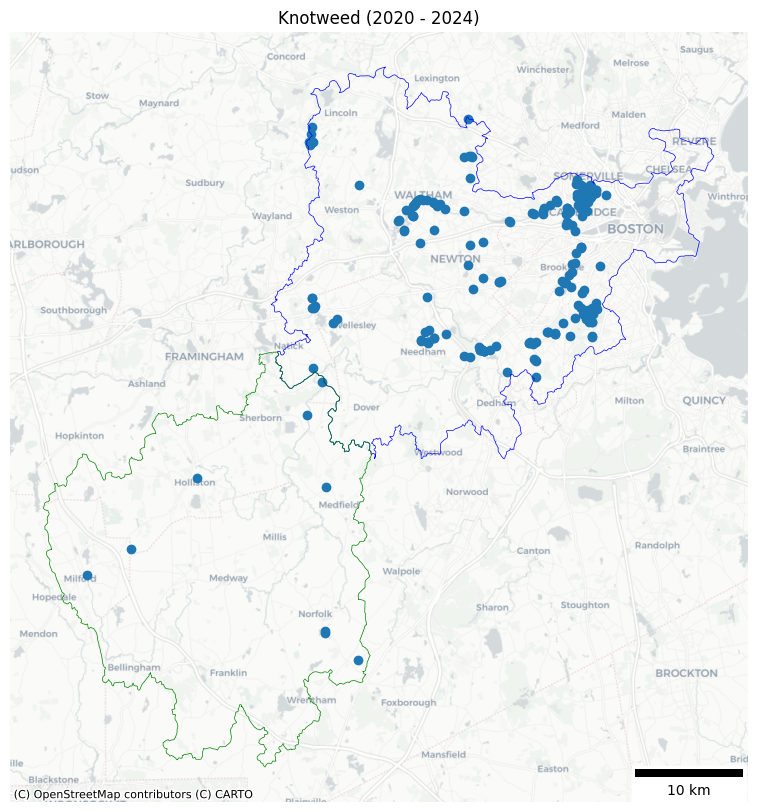

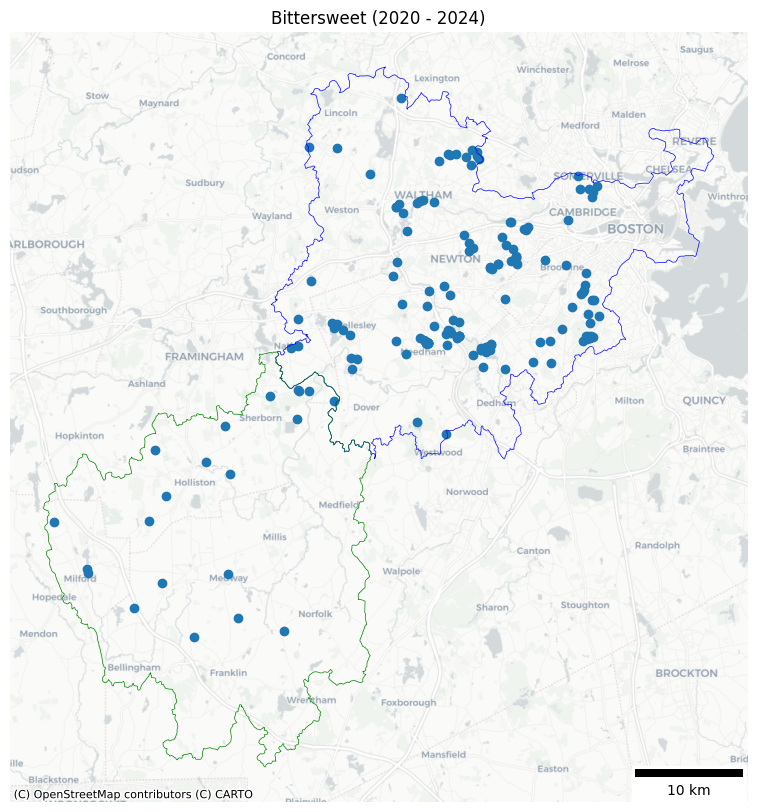

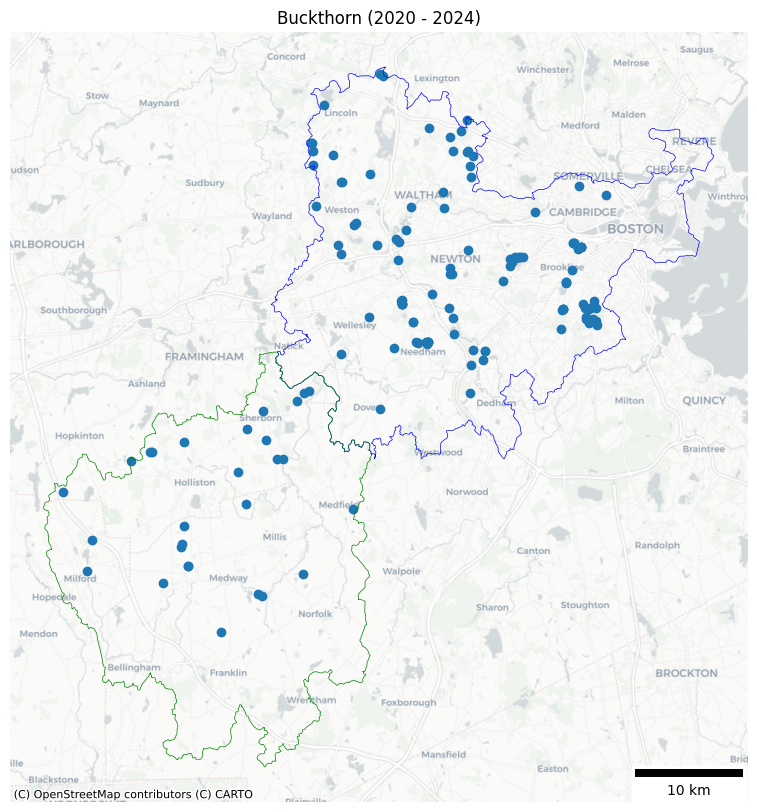

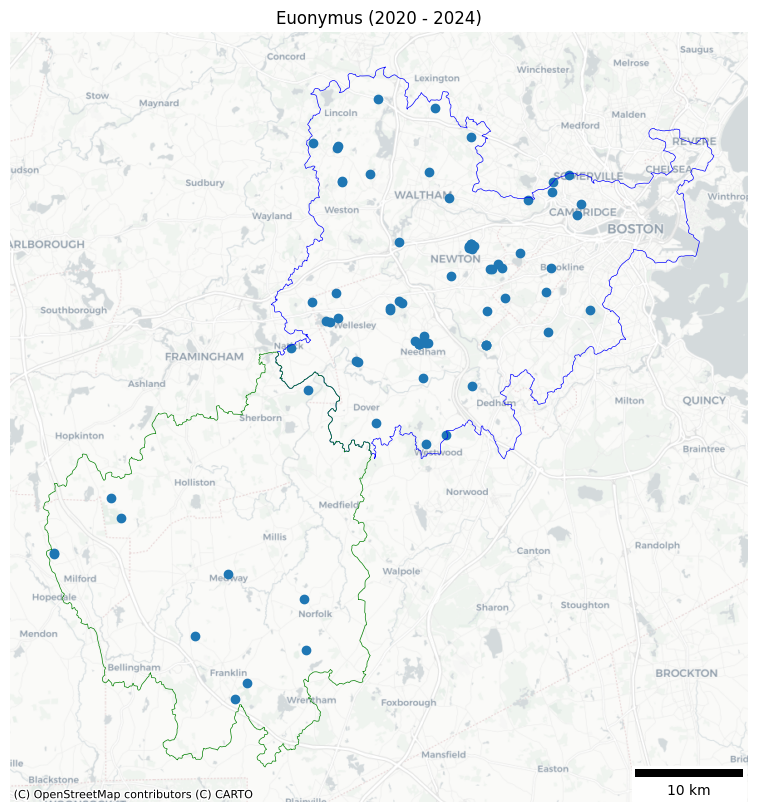

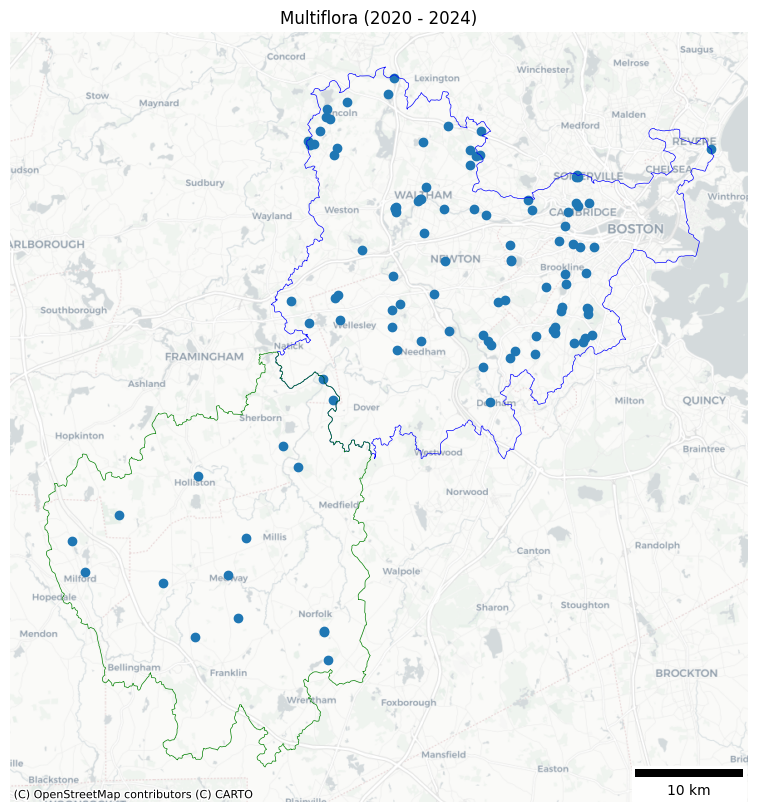

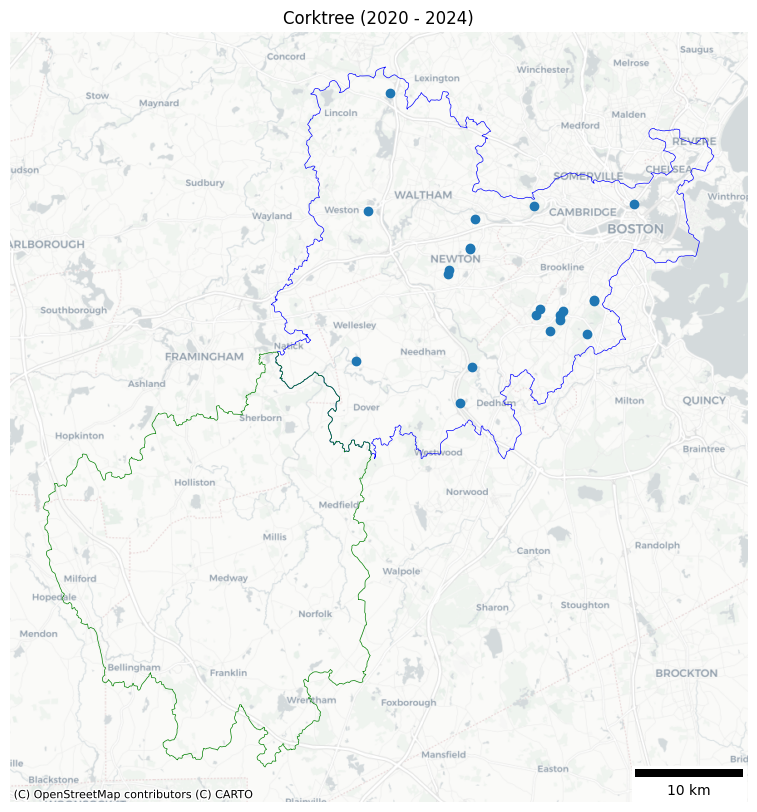

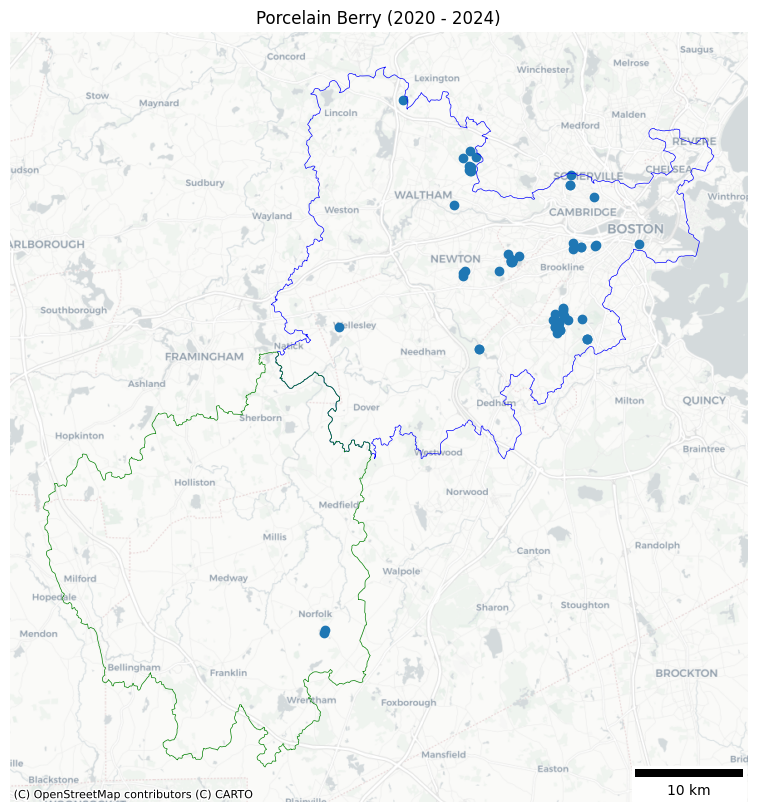

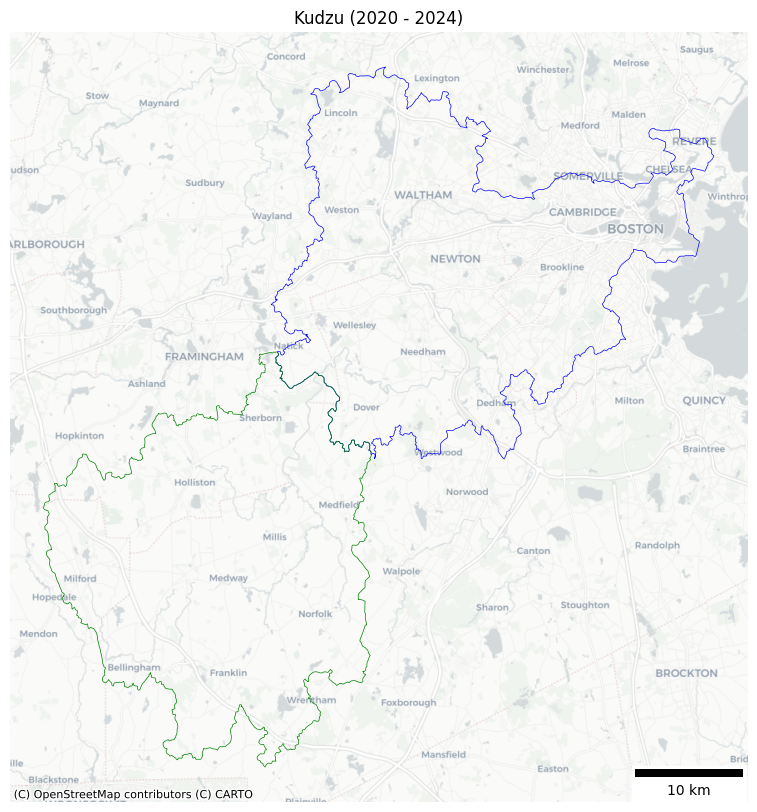

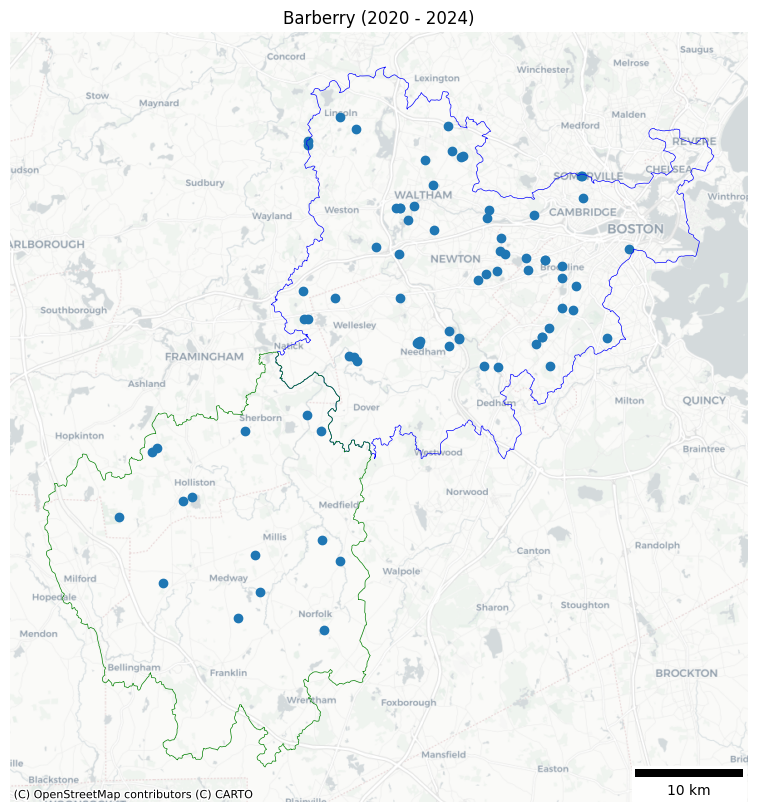

In [38]:
d={
  'Knotweed':knot_gdf,
  'Bittersweet':bitt_gdf,
  'Buckthorn':buck_gdf,
  'Euonymus':euon_gdf,
  'Multiflora':mult_gdf,
  'Corktree':cork_gdf,
  'Porcelain Berry':porc_gdf,
  'Kudzu':kudz_gdf,
  'Barberry':barb_gdf
}
for name, value in d.items():
  ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
  Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
  value.clip(Charles_gdf).to_crs(epsg=3857).plot(ax=ax)
  plt.title(name+" (2020 - 2024)")
  cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
  ax.set_axis_off()
  ax.add_artist(ScaleBar(1,location='lower right'))
  plt.savefig(name+'.png')

In [39]:
def extractPixel(image):
  return image.sample(test_point)

<IPython.core.display.HTML object>

In [40]:
coords=[barb_gdf.clip(Charles_gdf)['longitude'][96],barb_gdf.clip(Charles_gdf)['latitude'][96]]

<IPython.core.display.HTML object>

In [41]:
test_point=ee.Geometry.Point(coords)

<IPython.core.display.HTML object>

In [121]:
d_forest=NLCD2019lc.updateMask(NLCD2019lc.eq(41)).select('landcover').geometry()

<IPython.core.display.HTML object>

In [122]:
pd.DataFrame(data=S2_All.getRegion(d_forest,10).getInfo()[1:],columns=S2_All.getRegion(d_forest,10).getInfo()[0])

<IPython.core.display.HTML object>

EEException: ImageCollection.getRegion: Too many values: 196362220971 points x 15 bands x 1388 images > 1048576.

In [109]:
S2_TEST=pd.DataFrame(data=S2_All.getRegion(test_point,10).getInfo()[1:],columns=S2_All.getRegion(test_point,10).getInfo()[0])
date_format = "%m-%d-%Y"
for i in np.arange(0,S2_TEST['id'].size-1):
  time_str1=str(S2_TEST['id'][i+1][4:6])+'-'+str(S2_TEST['id'][i+1][6:8])+'-'+str(S2_TEST['id'][i+1][:4])
  time_str2=str(S2_TEST['id'][0][4:6])+'-'+str(S2_TEST['id'][0][6:8])+'-'+str(S2_TEST['id'][0][:4])
  S2_TEST['time'][i+1]=(datetime.strptime(time_str1,date_format)-datetime.strptime(time_str2,date_format)).days
S2_TEST.dropna(axis=0)

<IPython.core.display.HTML object>

<ipython-input-109-c3a67144e051>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S2_TEST['time'][i+1]=(datetime.strptime(time_str1,date_format)-datetime.strptime(time_str2,date_format)).days
<ipython-input-109-c3a67144e051>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S2_TEST['time'][i+1]=(datetime.strptime(time_str1,date_format)-datetime.strptime(time_str2,date_format)).days
<ipython-input-109-c3a67144e051>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

id  longitude  latitude  time  \
1    20190103T154641_20190103T155109_T19TCG -71.173924  42.27045     0   
2    20190113T154611_20190113T155046_T19TCG -71.173924  42.27045    10   
5    20190130T153551_20190130T154031_T19TCG -71.173924  42.27045    27   
6    20190202T154451_20190202T154921_T19TCG -71.173924  42.27045    30   
7    20190204T153559_20190204T154028_T19TCG -71.173924  42.27045    32   
..                                      ...        ...       ...   ...   
282  20221208T154629_20221208T154910_T19TCG -71.173924  42.27045  1435   
283  20221213T154641_20221213T154644_T19TCG -71.173924  42.27045  1440   
284  20221220T153641_20221220T153749_T19TCG -71.173924  42.27045  1447   
285  20221225T153649_20221225T153645_T19TCG -71.173924  42.27045  1452   
286  20221230T153641_20221230T153739_T19TCG -71.173924  42.27045  1457   

         B2      B3      B4    B5_10m    B6_10m    B7_10m      B8   B8A_10m  \
1    0.0506  0.0709  0.0931  0.114501  0.143119  0.152586  0.2048  0.182464   
2    0.0751  0.0964  0.1242  0.141039  0.161437  0.180749  0.2160  0.198642   
5    0.0739  0.0861  0.1066  0.126898  0.149806  0.159634  0.2160  0.186767   
6    0.1184  0.1366  0.1798  0.208097  0.234399  0.236710  0.2388  0.252161   
7    0.0653  0.0766  0.0913  0.116603  0.139565  0.152449  0.1932  0.177095   
..      ...     ...     ...       ...       ...       ...     ...       ...   
282  0.0650  0.0792  0.0990  0.134989  0.157450  0.166620  0.2040  0.187257   
283  0.0861  0.1142  0.1454  0.174510  0.194100  0.214332  0.2380  0.229099   
284  0.0646  0.0880  0.1086  0.141416  0.165025  0.176906  0.2156  0.195603   
285  0.0594  0.0684  0.0934  0.149402  0.182854  0.210611  0.2218  0.226912   
286  0.0877  0.1074  0.1310  0.153997  0.174230  0.187204  0.2170  0.217905   

      B11_10m   B12_10m      NDVI       NBR      SAVI    RENDVI       EVI  
1    0.175451  0.123901  0.374958 -0.246118  0.209989  0.111086  0.201785  
2    0.216547  0.170928  0.269841 -0.116487  0.163890  0.067436  0.164169  
5    0.150486  0.115505  0.339120 -0.303147  0.199489  0.082789  0.210166  
6    0.247315  0.208522  0.140946 -0.067688  0.096342  0.059439  0.103176  
7    0.195185  0.142576  0.358172 -0.150768  0.194837  0.089636  0.203596  
..        ...       ...       ...       ...       ...       ...       ...  
282  0.192967  0.153556  0.346535 -0.141080  0.196139  0.076805  0.200305  
283  0.197843  0.163790  0.241523 -0.184700  0.157233  0.053146  0.158058  
284  0.210307  0.167681  0.330043 -0.125024  0.194734  0.077043  0.193462  
285  0.253764  0.194774  0.407360 -0.064878  0.236261  0.100681  0.240144  
286  0.244014  0.192302  0.247126 -0.060343  0.152123  0.061643  0.159822  

[248 rows x 19 columns]

<IPython.core.display.HTML object>

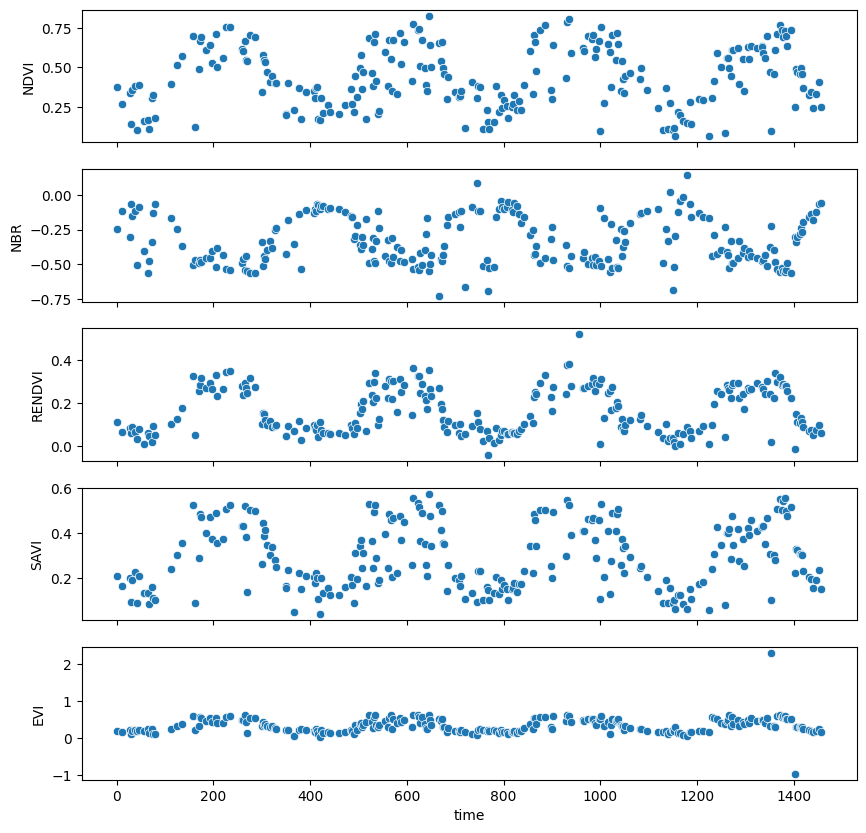

In [115]:
figure, axes = plt.subplots(5, 1, sharex=True,figsize=(10, 10))
sns.scatterplot(data=S2_TEST,x='time',y='NDVI',ax=axes[0])
sns.scatterplot(data=S2_TEST,x='time',y='NBR',ax=axes[1])
sns.scatterplot(data=S2_TEST,x='time',y='RENDVI',ax=axes[2])
sns.scatterplot(data=S2_TEST,x='time',y='SAVI',ax=axes[3])
sns.scatterplot(data=S2_TEST,x='time',y='EVI',ax=axes[4])
plt.show()

In [53]:
# Why do I get an error for some of the gifs I'm trying to generate but not others?
# How to extract pixel values from image collection so I can make time series graphs?
# How to get data stacked from my image collection into a matrix so I can run machine learning?



#Upsample if I want to make GIF

<IPython.core.display.HTML object>